In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
# hyper parameters
batch_size = 50
num_epochs = 5
learning_rate = 3e-4

In [4]:
train_set = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

class_list = train_set.classes

torch.Size([50, 3, 32, 32]) torch.Size([50])


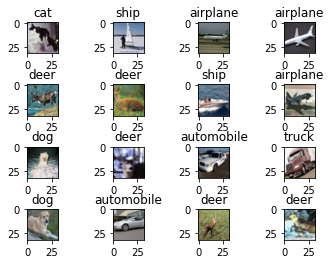

In [6]:
train_features, train_labels = next(iter(train_loader))
print(train_features.size(), train_labels.size())

fig, axs = plt.subplots(4, 4)
plt.subplots_adjust(wspace=0.1, hspace=1)
for i in range(16):
    img = torch.moveaxis(train_features[i], 0, 2)
    label = class_list[train_labels[i].item()]
    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].set_title(label)
plt.imshow(img)

In [7]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
linear = Linear().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear.parameters(), lr=learning_rate)

In [23]:
since = time.time()
linear.train()
loss_list = []
for epoch in range(num_epochs):
    for i, (img, label) in enumerate(tqdm(train_loader, leave=False, colour='cyan', desc=f'Epoch {epoch} / {num_epochs}', unit='batches')):
        img = img.to(device)
        img = img.reshape(img.shape[0], -1)
        label = label.to(device)

        optimizer.zero_grad()
        predict = linear(img)
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            loss_list.append(loss.item())

torch.cuda.empty_cache()

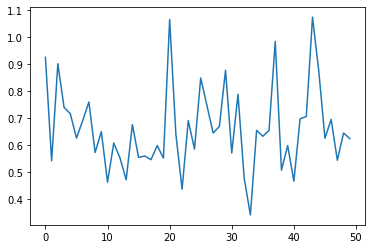

In [24]:
plt.plot(loss_list)

In [25]:
linear.eval()

Linear(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)

In [26]:
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.reshape(img.shape[0], -1)
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = linear(imgs)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print(f'Accruacy: {correct / total}')

Accruacy: 0.5419
